In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 4)

In [2]:
# load data
data_dic = {}
directory = '/Users/jinghan/Documents/UCB/Winter/IAQF_Competition/prediction'

for subdir in os.listdir(directory):
    
    if subdir != '.DS_Store':

        data_dic[subdir] = {}
        
        for filename in os.listdir(os.path.join(directory, subdir, 'predict')):
            
            if filename.endswith('_d.pkl'):
                data_dic[subdir]['D'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            elif filename.endswith('_w.pkl'):
                data_dic[subdir]['W'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            elif filename.endswith('_M.pkl'):
                data_dic[subdir]['M'] = pd.read_pickle(os.path.join(directory, subdir, 'predict',filename))
            else:
                pass

In [26]:
df = data_dic['lstm']['W'].copy()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
train_df = df[df.Date<'2017-01-01']
test_df = df[df.Date>='2017-01-01']

In [27]:
train_df = train_df.merge(train_df.groupby('pair')['actual_spread'].mean(), how='left', left_on='pair', right_index=True)
train_df = train_df.rename(columns={'actual_spread_x':'actual_spread', 'actual_spread_y':'actual_spread_mean'})
train_df['pred_m_mean'] = np.square(train_df['pred_spread'] - train_df['actual_spread_mean'])

In [50]:
def calculate_accuracy(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    df = df.reset_index(drop=True)
    df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d")
    train_df = df[df.Date<'2017-01-01']
    test_df = df[df.Date>='2017-01-01']

    train_df['abs_error'] = np.abs(train_df['actual_spread'] - train_df['pred_spread'])
    train_df['sqrt_error'] = np.square(train_df['actual_spread'] - train_df['pred_spread'])
    test_df['abs_error'] = np.abs(test_df['actual_spread'] - test_df['pred_spread'])
    test_df['sqrt_error'] = np.square(test_df['actual_spread'] - test_df['pred_spread'])

    def cal_pred_m_mean(df):
        df = df.copy()
        df = df.merge(df.groupby('pair')['actual_spread'].mean(), how='left', left_on='pair', right_index=True)
        df = df.rename(columns={'actual_spread_x':'actual_spread', 'actual_spread_y':'actual_spread_mean'})
        return np.square(df['actual_spread'] - df['actual_spread_mean'])

    train_df['sq_pred_m_mean'] = cal_pred_m_mean(train_df)
    test_df['sq_pred_m_mean'] = cal_pred_m_mean(test_df)

    measures = {}
    measures['train MAE'] = [train_df['abs_error'].mean()]
    measures['train RMSE'] = [np.sqrt(train_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    r2_cal = train_df.groupby('pair').aggregate({'sqrt_error':'sum','sq_pred_m_mean':'sum'})
    measures['train R2'] = [(1 - r2_cal['sqrt_error']/r2_cal['sq_pred_m_mean']).mean()]
    measures['test MAE'] = [test_df['abs_error'].mean()]
    measures['test RMSE'] = [np.sqrt(test_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    measures['test R2'] = [np.sqrt(test_df.groupby('pair').aggregate({'sqrt_error':'mean'})).mean().values[0]]
    r2_cal = test_df.groupby('pair').aggregate({'sqrt_error':'sum','sq_pred_m_mean':'sum'})
    measures['test R2'] = [(1 - r2_cal['sqrt_error']/r2_cal['sq_pred_m_mean']).mean()]

    err_df = pd.concat([train_df[['Date','pair','abs_error','sqrt_error']],test_df[['Date','pair','abs_error','sqrt_error']]], axis=0)

    timeseries_measures = {}
    timeseries_measures['mae'] = err_df.pivot(index='Date',columns='pair',values='abs_error').rolling(10).mean(skipna=True).mean(axis=1, skipna=True)
    timeseries_measures['rmse'] = np.sqrt(err_df.pivot(index='Date',columns='pair',values='sqrt_error').rolling(10).mean(skipna=True).mean(axis=1, skipna=True))

    return measures, timeseries_measures

In [51]:
def summarize_accuracy(data_dic, period):

    results_table = pd.DataFrame()
    mae_df = pd.DataFrame()
    rmse_df = pd.DataFrame()

    for k in data_dic.keys():

        if k != 'copula':

            if period in data_dic[k]:

                df = data_dic[k][period].copy()
                measures, timeseries_measures = calculate_accuracy(df)

                out = pd.DataFrame(measures)
                out['Period'] = period
                out['Model'] = k
                results_table = pd.concat([results_table,out],axis=0)

                mae_df[k] = timeseries_measures['mae']
                rmse_df[k] = timeseries_measures['rmse']

    results_table = results_table.groupby(['Period','Model']).max()

    plt.rcParams['figure.figsize'] = [18, 6]
    fig,ax = plt.subplots(2,1)
    ax[0].plot(mae_df)
    ax[0].legend(mae_df.columns)
    ax[0].set_title("MAE over time (Period = {})".format(period))
    ax[1].plot(rmse_df)
    ax[1].legend(rmse_df.columns)
    ax[1].set_title("RMSE over time (Period = {})".format(period))
    plt.show()
    
    return results_table

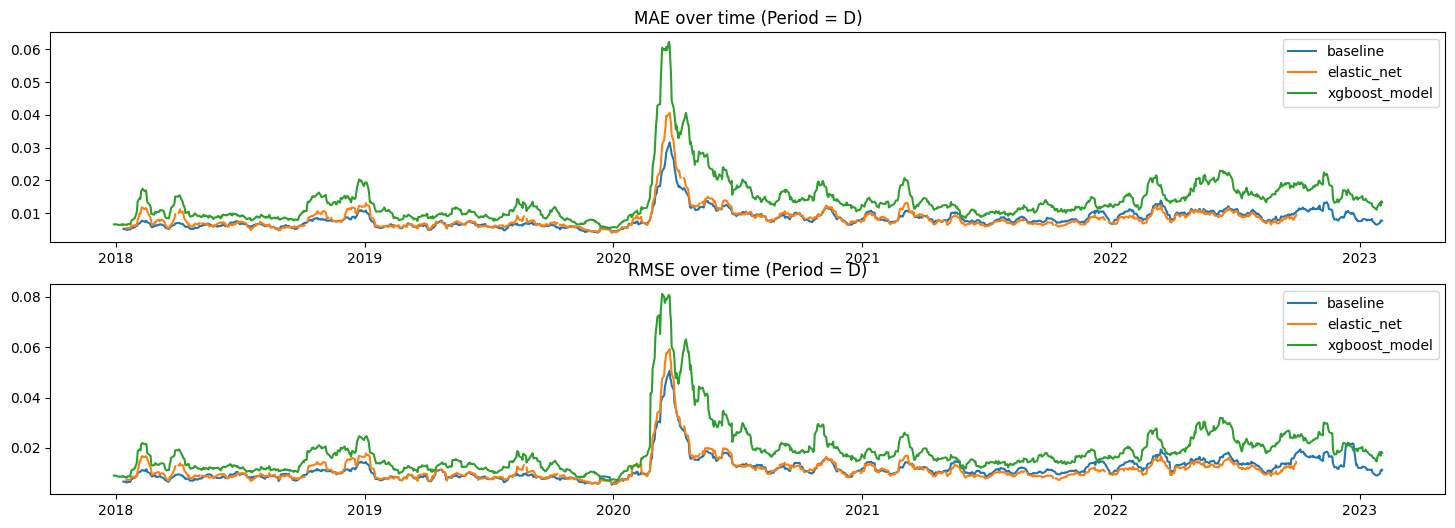

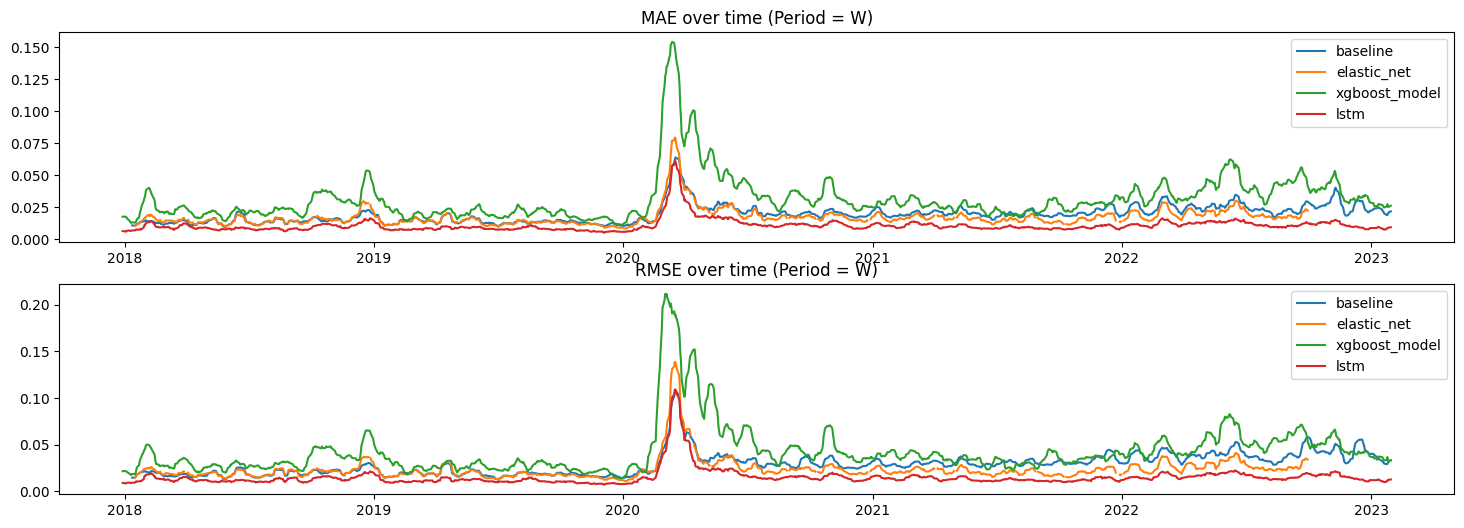

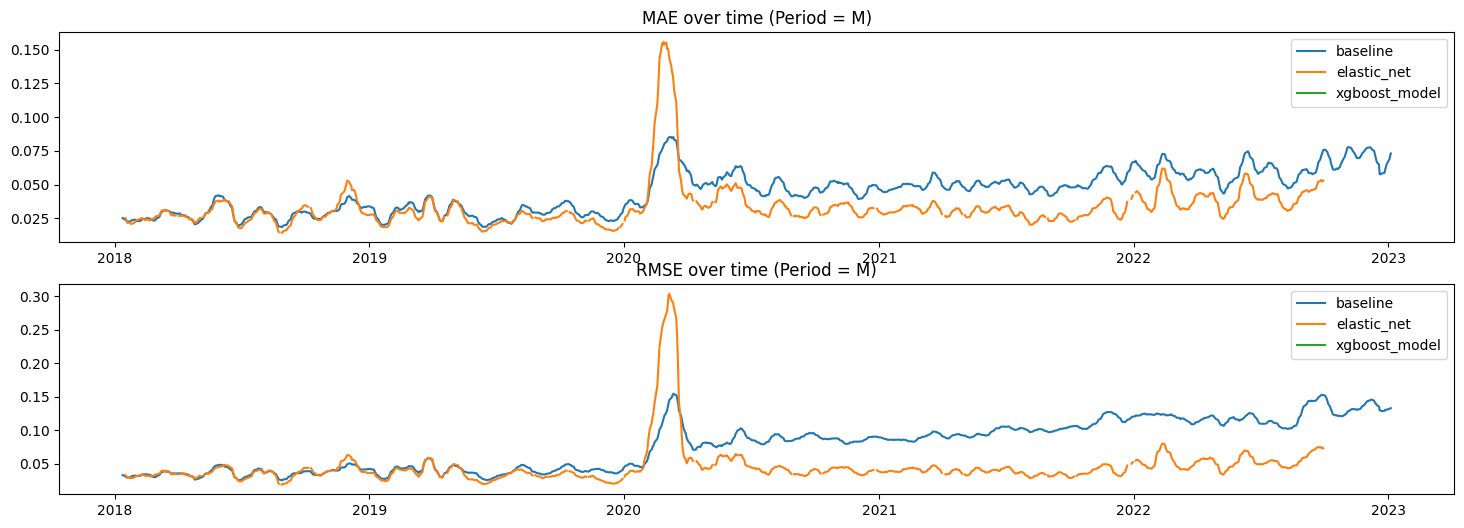

In [52]:
d_table = summarize_accuracy(data_dic, 'D')
w_table = summarize_accuracy(data_dic, 'W')
m_table = summarize_accuracy(data_dic, 'M')

results = pd.concat([d_table, w_table, m_table])

In [53]:
results

train MAE  train RMSE  train R2  test MAE  test RMSE  \
Period Model                                                                 
D      baseline             NaN         NaN       NaN    0.0083     0.0116   
       elastic_net          NaN         NaN       NaN    0.0085     0.0121   
       xgboost_model        NaN         NaN       NaN    0.0129     0.0191   
W      baseline             NaN         NaN       NaN    0.0195     0.0260   
       elastic_net          NaN         NaN       NaN    0.0173     0.0243   
       lstm              0.0106      0.0144    0.6369    0.0102     0.0151   
       xgboost_model        NaN         NaN       NaN    0.0291     0.0434   
M      baseline             NaN         NaN       NaN    0.0445     0.0564   
       elastic_net          NaN         NaN       NaN    0.0335     0.0484   
       xgboost_model     0.0145      0.0208   -0.2096       NaN        NaN   

                      test R2  
Period Model                   
D      baseline       -0.1061  
       elastic_net    -0.0005  
       xgboost_model  -0.0378  
W      baseline       -0.2929  
       elastic_net    -0.0006  
       lstm            0.5773  
       xgboost_model  -0.0512  
M      baseline       -1.3440  
       elastic_net    -0.0125  
       xgboost_model      NaN